In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
unconfined=True

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import pandas as pd
import sys
import os
import copy
import tqdm
import itertools
import numpy as np
from itertools import product
from _utils import assign_hydrogen_pdbinfo, map_mol_with_noe

# distance calc

In [3]:
!ls ../../../../Conformers/

CsA_baseline_numconf5400.pdb  CsA_chcl3_noebounds_numconf5400.pdb  Shuzhe


In [4]:
mol = Chem.MolFromPDBFile("../../../../Conformers/CsA_chcl3_noebounds_numconf5400.pdb", removeHs = False)

df = pd.read_csv("../CsA/CsA_chcl3_noebounds.csv", sep = "\s", comment = "#")

mol_atom_names2atom_index, noe_atom_names2mol_atom_names, noe_atom_pair2upper_distance = map_mol_with_noe(mol, df, verbose = False)

index_1, index_2 = [], [] #symmetric, thus two lists are interchangable
labels = []
ref_val = []
res_dist = [] # distance between residuals
bond_dist = [] # number of bonds between atoms

bond_order = Chem.rdmolops.GetDistanceMatrix(mol)

prev_a = 0 
prev_b = 0

for key, val in noe_atom_pair2upper_distance.items():
    tmp_1 = noe_atom_names2mol_atom_names[key[0]]
    tmp_2 = noe_atom_names2mol_atom_names[key[1]]
    #print(key[0])
    #print(tmp_1)
    a = mol_atom_names2atom_index[tmp_1]
    #print(tmp_2[0])
    b = mol_atom_names2atom_index[tmp_2]
    
    if not(b==prev_a and a==prev_b): # ignore reversed pair
        for item in product(a,b):
            #print(item)
            index_1.append(item[0]) # RDKit indexing starts at 0!
            index_2.append(item[1])
            ref_val.append(val)
            
            r1 = int(tmp_1[0]) # string to int conversion
            r2 = int(tmp_2[0])
            if abs(r1 - r2) <= 5: # take the shorter route along the ring, 11 residuals total
                dist = abs(r1 - r2)
            else:
                dist = abs(abs(r1 - r2) - 11)
            res_dist.append(dist)
            
            bd = int(bond_order[item[0], item[1]])
            bond_dist.append(bd)
            
            labels.append("{}-{} {}R {}B {}:{}{}-{}:{}{} ({:0.2f})".format(tmp_1[0], tmp_2[0], dist, bd, item[0], tmp_1[0], 
                                                                tmp_1[1], item[1], tmp_2[0], tmp_2[1], val))
    
    prev_a = a
    prev_b = b

# sort everything for bond_dist (first arg in zip) 
res_dist, bond_dist, labels, ref_val, index_1, index_2 = (list(t) for t in zip(*sorted(zip(bond_dist, res_dist, labels, ref_val, index_1, index_2))))

distance_matrix_for_each_conformer = np.array([Chem.Get3DDistanceMatrix(mol, i) for i in tqdm.tqdm(range(mol.GetNumConformers()))])

with_noe = distance_matrix_for_each_conformer[:, index_1, index_2]

bl_mol = Chem.MolFromPDBFile("../../../../Conformers/CsA_baseline_numconf5400.pdb", removeHs = False)
distance_matrix_for_each_conformer = np.array([Chem.Get3DDistanceMatrix(bl_mol, i) for i in tqdm.tqdm(range(mol.GetNumConformers()))])
baseline = distance_matrix_for_each_conformer[:, index_1, index_2]

/home/kkajo/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 5400/5400 [00:02<00:00, 2019.67it/s]


In [5]:
#tmp_1

In [6]:
#bond_order = Chem.rdmolops.GetDistanceMatrix(mol)
#bond_order.shape

In [7]:
#bond_order[:10, :10]

In [8]:
#labels

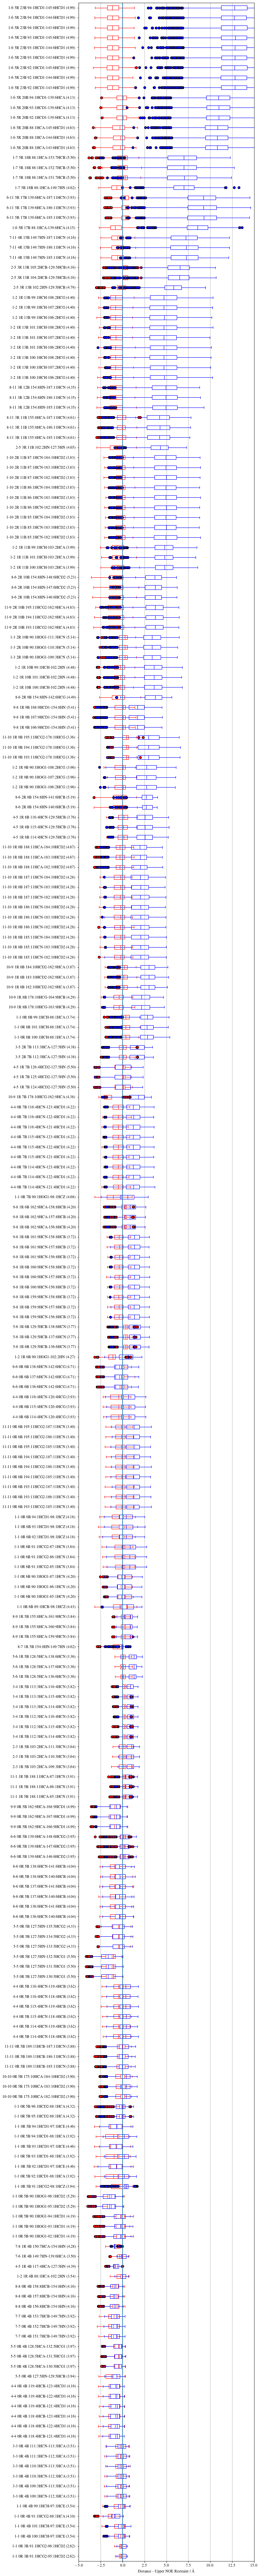

CPU times: user 9.84 s, sys: 647 ms, total: 10.5 s
Wall time: 10.8 s


In [9]:
plot_1 = copy.copy(with_noe) - ref_val
plot_2 = copy.copy(baseline) - ref_val

widths = 0.4
offset = 0.2
fig1, ax1 = plt.subplots(1, 1, figsize = (8,120))
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
# ax1.set_title('Basic Plot')
red_square = dict(markerfacecolor='r', marker='o')
blue_square = dict(markerfacecolor='b', marker='o')

bp_1 = ax1.boxplot([plot_1[:,i] for i in range(plot_1.shape[1])], vert = False, widths = widths, 
                   flierprops = red_square, positions = np.array(range(plot_1.shape[1])), manage_ticks=False)
bp_2 = ax1.boxplot([plot_2[:,i] for i in range(plot_2.shape[1])], vert = False, widths = widths, 
                   flierprops = blue_square, positions = np.array(range(plot_2.shape[1])), manage_ticks=False)

set_box_color(bp_1, "red")
set_box_color(bp_2, "blue")
# with the offset it takes much longer to plot
#ax1.boxplot([plot_1[:,i] for i in range(plot_1.shape[1])], positions = np.array(range(plot_1.shape[1])) + offset, vert = False, flierprops = red_square, widths = widths)
#ax1.boxplot([plot_2[:,i] for i in range(plot_2.shape[1])], positions = np.array(range(plot_2.shape[1])) - offset, vert = False, flierprops = blue_square, widths = widths)

ax1.set_xlabel('Distance - Upper NOE Restraint / Å')
plt.grid(axis = "x", which = "both")
# plt.grid(axis = "y", which = "major")
# plt.axvline(x=2.20589566)
plt.yticks(range(plot_1.shape[1]), labels)
plt.ylim(0 - 0.5, plot_1.shape[1] - 0.5)
plt.xlim(-5, 15)
plt.axvline(x=0)

%time plt.show()

# check if any conformer satisfy all restraints

In [10]:
tmp = copy.copy(with_noe) - ref_val
tmp[tmp < 0] = 0
best_ind = (np.argsort(np.sum(tmp, 1))[:20])

print("indices of best: {}".format(best_ind))

least_violation = []
for i in best_ind:
    least_violation.append(np.sum(tmp,1)[i])
print("summed violations of best: {}".format(np.around(np.array(least_violation),2)))
if least_violation[0]>0:
    print('no conformer fulfills all NOE restraints')

indices of best: [3489 1089 3207 1741 2945 1987  522 1734 4070 2327 1845 1216 4047 3187
  391 4728 2919  238 4197  631]
summed violations of best: [23.16 23.82 23.97 23.99 23.99 24.18 24.27 24.32 24.33 24.36 24.51 24.61
 24.82 24.82 24.92 25.06 25.08 25.14 25.15 25.2 ]
no conformer fulfills all NOE restraints


In [11]:
"""
plot_1, plot_2 = with_noe, baseline

#print(sum(np.all((plot_1 - ref_val) < 0, 1)))
#print(sum(np.all((plot_2 - ref_val) < 0, 1)))


widths = 0.4
offsets = 0.2
fig1, ax1 = plt.subplots(1, 1, figsize = (8,250))
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
# ax1.set_title('Basic Plot')
red_square = dict(markerfacecolor='r', marker='o')
blue_square = dict(markerfacecolor='b', marker='o')

bp_1 = ax1.boxplot([plot_1[:,i] for i in range(plot_1.shape[1])], vert = False, widths = widths, flierprops = red_square)
bp_2 = ax1.boxplot([plot_2[:,i] for i in range(plot_2.shape[1])], vert = False, widths = widths, flierprops = blue_square)

set_box_color(bp_1, "red")
set_box_color(bp_2, "blue")
## with the offset it takes much longer to plot
# ax1.boxplot([plot_1[:,i] for i in range(plot_1.shape[1])], positions = np.array(range(plot_1.shape[1])) + offset, vert = False, flierprops = red_square, widths = width)
# ax1.boxplot([plot_2[:,i] for i in range(plot_2.shape[1])], positions = np.array(range(plot_2.shape[1])) - offset, vert = False, flierprops = blue_square, widths = width)

ax1.set_xlabel('Distance (Å)')
plt.grid(axis = "x", which = "both")
# plt.grid(axis = "y", which = "major")
# plt.axvline(x=2.20589566)
plt.yticks(range(plot_1.shape[1]), labels)
#%time plt.show()
"""

'\nplot_1, plot_2 = with_noe, baseline\n\n#print(sum(np.all((plot_1 - ref_val) < 0, 1)))\n#print(sum(np.all((plot_2 - ref_val) < 0, 1)))\n\n\nwidths = 0.4\noffsets = 0.2\nfig1, ax1 = plt.subplots(1, 1, figsize = (8,250))\ndef set_box_color(bp, color):\n    plt.setp(bp[\'boxes\'], color=color)\n    plt.setp(bp[\'whiskers\'], color=color)\n    plt.setp(bp[\'caps\'], color=color)\n    plt.setp(bp[\'medians\'], color=color)\n# ax1.set_title(\'Basic Plot\')\nred_square = dict(markerfacecolor=\'r\', marker=\'o\')\nblue_square = dict(markerfacecolor=\'b\', marker=\'o\')\n\nbp_1 = ax1.boxplot([plot_1[:,i] for i in range(plot_1.shape[1])], vert = False, widths = widths, flierprops = red_square)\nbp_2 = ax1.boxplot([plot_2[:,i] for i in range(plot_2.shape[1])], vert = False, widths = widths, flierprops = blue_square)\n\nset_box_color(bp_1, "red")\nset_box_color(bp_2, "blue")\n## with the offset it takes much longer to plot\n# ax1.boxplot([plot_1[:,i] for i in range(plot_1.shape[1])], positions =

In [12]:
"""
plot_1, plot_2 = copy.copy(with_noe), copy.copy(baseline)
plot_1 -= ref_val
plot_2 -= ref_val

widths = 0.4
offsets = 0.2
fig1, ax1 = plt.subplots(1, 1, figsize = (8,250))
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
# ax1.set_title('Basic Plot')
red_square = dict(markerfacecolor='r', marker='o')
blue_square = dict(markerfacecolor='b', marker='o')

bp_1 = ax1.boxplot([plot_1[:,i] for i in range(plot_1.shape[1])], vert = False, widths = widths, flierprops = red_square)
bp_2 = ax1.boxplot([plot_2[:,i] for i in range(plot_2.shape[1])], vert = False, widths = widths, flierprops = blue_square)

set_box_color(bp_1, "red")
set_box_color(bp_2, "blue")
## with the offset it takes much longer to plot
# ax1.boxplot([plot_1[:,i] for i in range(plot_1.shape[1])], positions = np.array(range(plot_1.shape[1])) + offset, vert = False, flierprops = red_square, widths = width)
# ax1.boxplot([plot_2[:,i] for i in range(plot_2.shape[1])], positions = np.array(range(plot_2.shape[1])) - offset, vert = False, flierprops = blue_square, widths = width)

ax1.set_xlabel('Distance (Å)')
plt.grid(axis = "x", which = "both")
# plt.grid(axis = "y", which = "major")
plt.axvline(x=0)
plt.yticks(range(plot_1.shape[1]), labels)
%time plt.show()
"""


'\nplot_1, plot_2 = copy.copy(with_noe), copy.copy(baseline)\nplot_1 -= ref_val\nplot_2 -= ref_val\n\nwidths = 0.4\noffsets = 0.2\nfig1, ax1 = plt.subplots(1, 1, figsize = (8,250))\ndef set_box_color(bp, color):\n    plt.setp(bp[\'boxes\'], color=color)\n    plt.setp(bp[\'whiskers\'], color=color)\n    plt.setp(bp[\'caps\'], color=color)\n    plt.setp(bp[\'medians\'], color=color)\n# ax1.set_title(\'Basic Plot\')\nred_square = dict(markerfacecolor=\'r\', marker=\'o\')\nblue_square = dict(markerfacecolor=\'b\', marker=\'o\')\n\nbp_1 = ax1.boxplot([plot_1[:,i] for i in range(plot_1.shape[1])], vert = False, widths = widths, flierprops = red_square)\nbp_2 = ax1.boxplot([plot_2[:,i] for i in range(plot_2.shape[1])], vert = False, widths = widths, flierprops = blue_square)\n\nset_box_color(bp_1, "red")\nset_box_color(bp_2, "blue")\n## with the offset it takes much longer to plot\n# ax1.boxplot([plot_1[:,i] for i in range(plot_1.shape[1])], positions = np.array(range(plot_1.shape[1])) + offs

# Calculate RMSD of Conformers

In [13]:
import mdtraj as md
import cpeptools
import tempfile
def get_rmsd(smiles, pdb_path, ref_pdb_path): #not full rmsd, just ring + beta atom rmsd
    smiles_mol = Chem.MolFromSmiles(smiles)
    ref_mol = Chem.MolFromPDBFile(ref_pdb_path)
    mol = Chem.MolFromPDBFile(pdb_path)

    ref_mol = AllChem.AssignBondOrdersFromTemplate(smiles_mol,ref_mol)
    mol = AllChem.AssignBondOrdersFromTemplate(smiles_mol, mol)
    order = list(mol.GetSubstructMatches(ref_mol)[0])
    mol = Chem.RenumberAtoms(mol, order)

    indices = cpeptools.get_largest_ring(ref_mol)
    indices = cpeptools.mol_ops.get_neighbour_indices(ref_mol, indices)
    #assert len(set(indices) - set(cpeptools.get_largest_ring(mol))) == 0, "ring atom indices do not agree"

    tmp_dir = tempfile.mkdtemp()
    ref_pdb_filename = tempfile.mktemp(suffix=".pdb", dir = tmp_dir)
    pdb_filename = tempfile.mktemp(suffix=".pdb", dir = tmp_dir)
    # chem add Hs
    Chem.MolToPDBFile(ref_mol, ref_pdb_filename)
    Chem.MolToPDBFile(mol, pdb_filename)

    ref  = md.load(ref_pdb_filename)
    #ref = ref.center_coordinates()
    compare = md.load(pdb_filename)
    #compare = compare.center_coordinates()
    #print(compare, mol.GetNumConformers())
    print(" {} has {} conformers".format(smiles, len(compare)))


    bb_rmsd = md.rmsd(compare, ref, 0, atom_indices = indices)
    compare = compare.superpose(ref, 0, atom_indices = indices)
    ten_best = compare[np.argsort(bb_rmsd)[-1:]]
    return bb_rmsd, compare[np.argmin(bb_rmsd)], ten_best

In [14]:
md.load("../../../../Conformers/CsA_chcl3_noebounds_numconf5400.pdb")[0].save("./tmp.pdb")
%time bb_rmsd, tmp, ten_tmp = get_rmsd("CC[C@H]1C(=O)N(CC(=O)N([C@H](C(=O)N[C@H](C(=O)N([C@H](C(=O)N[C@H](C(=O)N[C@@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N1)[C@@H]([C@H](C)C/C=C/C)O)C)C(C)C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C", "../../../../Conformers/CsA_chcl3_noebounds_numconf5400.pdb", "../CsA/ref.pdb")

 CC[C@H]1C(=O)N(CC(=O)N([C@H](C(=O)N[C@H](C(=O)N([C@H](C(=O)N[C@H](C(=O)N[C@@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N([C@H](C(=O)N1)[C@@H]([C@H](C)C/C=C/C)O)C)C(C)C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C has 5400 conformers
CPU times: user 12.6 s, sys: 283 ms, total: 12.9 s
Wall time: 12.7 s


In [15]:
ten_tmp

<mdtraj.Trajectory with 1 frames, 85 atoms, 11 residues, without unitcells at 0x7f42c4d75fd0>

# Visualization

In [16]:
tmp.save("./rmsd_tmp.pdb")
ten_tmp.save("./rmsd_ten_tmp.pdb")

Compare best to reference

In [17]:
import nglview as nv

view = nv.show_file("./rmsd_tmp.pdb")
view.add_representation('cartoon', selection='protein', color='black')
view.add_component("../CsA/ref.pdb", color='blue')

view

NGLWidget()

Show variation of the ten best structures

In [18]:


#view2 = nv.show_file("./rmsd_tmp.pdb")

view2 = nv.show_structure_file("./rmsd_ten_tmp.pdb", default_representation=False)
view2.add_component("../CsA/ref.pdb", selection='protein', color='black')
view2.add_representation('licorice', selection='protein', color='atomindex')
view2.center()
view2

NGLWidget()

Atomic structure of best fit

In [19]:
view3 = nv.show_file("./rmsd_tmp.pdb")
view3.add_cartoon("protein", color_scheme="residueindex")
view3.add_ball_and_stick("protein")
view3

NGLWidget()

# Graphics testing

Get some random data

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

# fake up some data
spread = np.random.rand(50) * 100
center = np.ones(25) * 50
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center, flier_high, flier_low))

Plot it

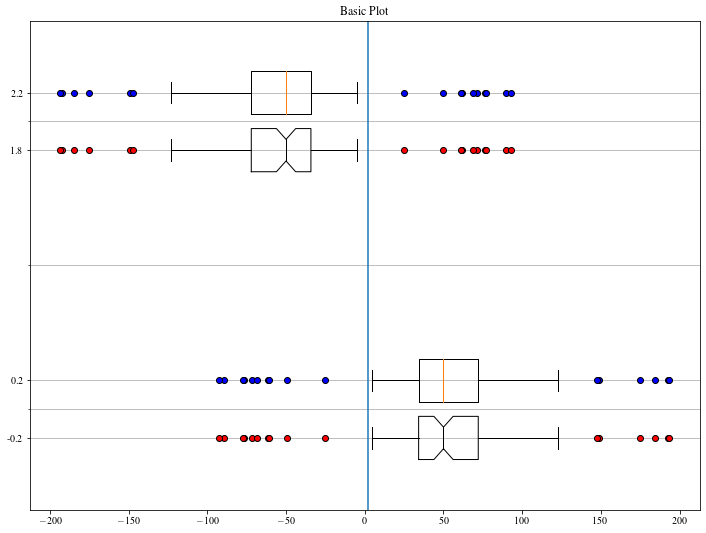

In [21]:
fig1, ax1 = plt.subplots(1, 1, figsize = (12,9))
ax1.set_title('Basic Plot')
red_square = dict(markerfacecolor='r', marker='o')
blue_square = dict(markerfacecolor='b', marker='o')
median = dict(color='k')
ax1.boxplot([data, -data], notch = True, positions = np.array(range(2))*2.0-0.2, vert = False, flierprops = red_square, medianprops = median)
ax1.boxplot([data, -data], positions = np.array(range(2))*2.0+0.2, vert = False, flierprops = blue_square, whis=1.5)
ax1.set_yticks([0,1,2], minor=True)
plt.grid(axis = "y", which = "both")
#plt.grid(axis = "x", which = "major")
plt.axvline(x=2.20589566)

plt.show()